# Predicting Tesla stock price with LSTM 

At this point, we wanted to explore methods beyond what was taught in our syllabus to learn more about the stock market via the Alpha Vantage API.

We read up about LSTM and how it is a great model for time series scenarios. Also, we have been following Elon Musk's Tesla and its meteoric rise the past few years. Naturally, a relevant and intersting problem to explore is how to use LSTM to predict its stock price!

### First, import all neccessary modules, including some keras dependencies

In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


### We are going to get our Tesla stock data from trusty 'ol Alpha Vantage, again making sure that the output format is 'pandas'

In [2]:
from alpha_vantage.timeseries import TimeSeries
API_KEY = 'ZLL997KKZMX2B4BL'
app = TimeSeries(API_KEY, output_format='pandas')

In [3]:
# Get recent stock information on Tesla from Alpha Vantage
TSLA = app.get_daily_adjusted('TSLA', outputsize='full')[0]
TSLA = pd.DataFrame(TSLA)[:1259]
TSLA

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2021-04-16,728.65,749.4100,724.600,739.78,739.780,27979526.0,0.0,1.0
2021-04-15,743.10,743.6900,721.310,738.85,738.850,27848900.0,0.0,1.0
2021-04-14,770.70,780.7900,728.030,732.23,732.230,49017434.0,0.0,1.0
2021-04-13,712.70,763.0000,710.660,762.32,762.320,44652808.0,0.0,1.0
2021-04-12,685.70,704.8000,682.090,701.98,701.980,29135670.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2016-04-22,248.89,254.0000,245.710,253.75,50.750,3786327.0,0.0,1.0
2016-04-21,248.99,250.9000,246.910,248.29,49.658,2783059.0,0.0,1.0
2016-04-20,246.26,253.6600,241.500,249.97,49.994,5194051.0,0.0,1.0


### Data cleaning and shaping

In [4]:
# Reassigning as df for easier referencing later on
df = TSLA
df = df.iloc[::-1].reset_index()    # Here we set date as an actual column in dataframe, and reindex!
df

,date,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
0,2016-04-18,252.23,258.3100,251.660,253.88,50.776,4271362.0,0.0,1.0
1,2016-04-19,253.12,254.3699,241.251,247.37,49.474,6357526.0,0.0,1.0
2,2016-04-20,246.26,253.6600,241.500,249.97,49.994,5194051.0,0.0,1.0
3,2016-04-21,248.99,250.9000,246.910,248.29,49.658,2783059.0,0.0,1.0
4,2016-04-22,248.89,254.0000,245.710,253.75,50.750,3786327.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
1254,2021-04-12,685.70,704.8000,682.090,701.98,701.980,29135670.0,0.0,1.0
1255,2021-04-13,712.70,763.0000,710.660,762.32,762.320,44652808.0,0.0,1.0
1256,2021-04-14,770.70,780.7900,728.030,732.23,732.230,49017434.0,0.0,1.0
1257,2021-04-15,743.10,743.6900,721.310,738.85,738.850,27848900.0,0.0,1.0


### Do a quick visualisation of Tesla's historic stock price data

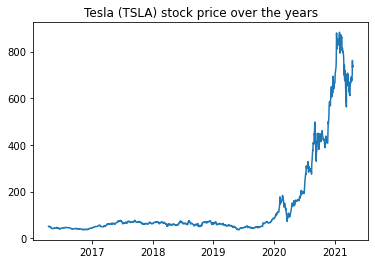

In [5]:
plt.plot(df['date'], df['5. adjusted close'])
plt.title('Tesla (TSLA) stock price over the years')
plt.show()

## The actual training part! 

### Like always, we split into training and test sets

In [6]:
training_set = df.iloc[:800, [5]].values
test_set = df.iloc[800:, [5]].values

### Using the MinMaxScaler (learned this by watching youtube videos)

In [7]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-50:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
# Using keras sequential model!

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 6s 55ms/step - loss: 0.1598
Epoch 2/100
24/24 [==============================] - 1s 52ms/step - loss: 0.0308
Epoch 3/100
24/24 [==============================] - 1s 57ms/step - loss: 0.0173
Epoch 4/100
24/24 [==============================] - 1s 59ms/step - loss: 0.0163
Epoch 5/100
24/24 [==============================] - 1s 56ms/step - loss: 0.0190
Epoch 6/100
24/24 [==============================] - 2s 66ms/step - loss: 0.0154
Epoch 7/100
24/24 [==============================] - 2s 68ms/step - loss: 0.0151
Epoch 8/100
24/24 [==============================] - 2s 69ms/step - loss: 0.0173
Epoch 9/100
24/24 [==============================] - 2s 65ms/step - loss: 0.0145
Epoch 10/100
24/24 [==============================] - 2s 66ms/step - loss: 0.0162
Epoch 11/100
24/24 [==============================] - 2s 71ms/step - loss: 0.0170
Epoch 12/100
24/24 [==============================] - 2s 62ms/step - loss: 0.0136
Epoch 13/100
24/24 [=====

### Once training is done, we want to shape our data

In [9]:
# Getting the predicted stock price
dataset_train = pd.DataFrame(df['5. adjusted close'][:800])
dataset_test = pd.DataFrame(df['5. adjusted close'][800:])
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-50:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(459, 50, 1)


In [10]:
# Quick check to see the data
dataset_test

,5. adjusted close
800,44.372
801,44.728
802,43.952
803,43.854
804,44.568
...,...
1254,701.980
1255,762.320
1256,732.230
1257,738.850


In [11]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

### Finally, lets visualise the training results!

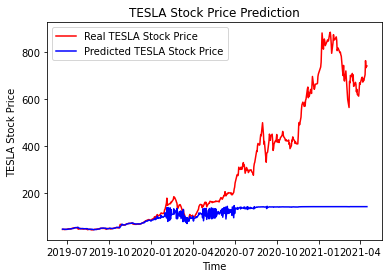

In [12]:
# Visualising the results
plt.plot(df['date'][800:],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df['date'][800:],predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

## Conclusion

As seen, the LSTM model is not very good at predicting Tesla's stock price... This was no surprise to us because nobody, even the pros, predicted that TSLA stock price would have risen so dramatically over the past year or so. 

Since this LSTM was trained using older data from Tesla's earlier days where stock price was trading rather steadily below the 200 range, the model does not correctly predict the shoot up to the $800+ range in late 2020/2021. 

That said, this model still managed to predict the small up/down movements in the stock price relatively well.

Finally, let us try a different model, the ARIMA model, to see if we can get better results. **Check out our last notebook!**